### Train simple CNN on large image area

In [11]:
# import pandas as pd
import numpy as np
from numpy import load
from numpy import genfromtxt
import json
import tensorflow as tf
from synspy.analyze.util import load_segment_status_from_csv,dump_segment_info_to_csv
import tifffile as tif
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.metrics import accuracy_score

from keras.models import Sequential, model_from_json
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

%reload_ext autoreload
%autoreload 2

In [12]:
import time

In [13]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10466034753044616244
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 13618838897
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8508046626127998710
physical_device_desc: "device: 0, name: Quadro P5000, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [14]:
# data approved by Bill 

segmentation = []
segmentation.append('ImgZfDsy20171201A3A')
segmentation.append('ImgZfDsy20170921A3C') 
# segmentation.append('ImgZfZdu20171121A3C') # this one IS in the cohort !!! oh no !!! 
segmentation.append('ImgZfZdu20171201B3C') # new
segmentation.append('ImgZfZdu20171020A3A') # new
segmentation.append('ImgZfDsy20171207B3A') # new
segmentation.append('ImgZfZdu20170920B3B')
segmentation.append('ImgZfDsy20170915D3A')

In [15]:
from utils import *

#### load data:

In [17]:
start = time.time()

padding = np.array([0,32,32]) # ZYX, so the input image size is [1,65,65]
int_padding = np.array([0,3,3])
volumes, synapse_dataset, labels = get_train_data(segmentation,padding,int_padding)

end = time.time()
print(f"\nTime to load data : {end - start} sec")

Potential synapses:375885

Time to load data : 63.3103563785553


#### split into train and test:

In [18]:
start = time.time()

# chose the method to split
unequal_split = 0
split_strat = 1

if unequal_split:
    # Split unequal train/test
    X_train, X_test, y_train, y_test = split_data_more0(volumes,labels,3)
    print("Using custom unbalanced split")
    print('Train 0: ',np.sum(y_train==0), ',1: ',np.sum(y_train==1))
    print('Test 0: ',np.sum(y_test==0), ',1: ',np.sum(y_test==1))
if split_strat:
    from sklearn.model_selection import StratifiedShuffleSplit
    strat = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=1)

    for train_index , test_index in strat.split(volumes, labels):
        X_train = volumes[train_index,:]
        y_train = labels[train_index]
        X_test = volumes[test_index,:]
        y_test = labels[test_index]
    print("Using Stratified Shuffle Split")
    print(f"Train data : {y_train.shape[0]} samples, test data: {y_test.shape[0]}")
    
# calculate class weights
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(np.squeeze(np.array(y_train))),
                                                np.squeeze(np.array(y_train)))
print(f"class_weights : {class_weights}")

end = time.time()
print(f"\nTime to split data : {end - start} sec")

Using Stratified Shuffle Split
Train data : 281913 samples, test data: 93972
class_weights : [ 0.51625799 15.87705564]

Time to split data : 6.287546157836914 sec


#### define CNN structure:

In [27]:
with tf.device('/GPU:0'):
    model65 = Sequential()

    model65.add(Conv2D(16, kernel_size=3, activation='relu', input_shape=(65,65,1), name='conv_1'))
    model65.add(Conv2D(16, kernel_size=3, activation='relu', name='conv_2'))
    model65.add(MaxPooling2D(pool_size=2))
    model65.add(Conv2D(32, kernel_size=3, activation='relu', name='conv_3'))
    model65.add(Conv2D(32, kernel_size=3, activation='relu', name='conv_4'))
    model65.add(MaxPooling2D(pool_size=2))
    model65.add(Conv2D(32, kernel_size=3, activation='relu', name='conv_5'))
    model65.add(Conv2D(32, kernel_size=3, activation='relu', name='conv_6'))
    model65.add(Flatten())
    model65.add(Dense(128, activation='relu', name='dense_1'))
    model65.add(Dense(1,activation='sigmoid', name='output'))

    model65.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    model65.summary()
    # from keras.utils import plot_model
    # plot_model(model, to_file='model.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 63, 63, 16)        160       
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 16)        2320      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 32)        4640      
_________________________________________________________________
conv_4 (Conv2D)              (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv_5 (Conv2D)              (None, 11, 11, 32)        9248      
__________

#### train cnn: 

In [ ]:
start = time.time()
# following this paper :
# https://towardsdatascience.com/
# visualizing-intermediate-activation-in-convolutional-neural-networks-with-keras-260b36d60d0

model65.load_weights(save_model_as)
save_model_as = "img65_acc_weighted_30_stratif.hdf5"
custom_weights = {0: 1., 1: 30.}

with tf.device('/GPU:0'):
    checkpointer = ModelCheckpoint(filepath=save_model_as, 
                               monitor = 'val_acc',
                               verbose=1, 
                               save_best_only=True)

    history = model65.fit(X_train, y_train,
                                epochs=10,
                                batch_size=8000, #5000
                                callbacks=[checkpointer],
                                validation_data = (X_test, y_test),
                                class_weight = custom_weights)

    # model.fit(X_train, y_train,epochs=25,batch_size=20)
    # model.evaluate(X_test, y_test, batch_size=20)
    
end = time.time()
print(f"\nTime to train cnn : {end - start} sec")

#### Predict the response for test and validation datasets
So far img65_acc_weighted_20_stratif.hdf5 looks the best based on the f1 score. best_weights_imgSize65.hdf5 (the old trained network) is also pretty discent. 


In [30]:
from plot_utils import *

start = time.time()
eval_segmentation = ['ImgZfZdu20171121A3C']
X_eval, synapse_eval, y_eval = get_train_data(eval_segmentation,padding,int_padding)

end = time.time()
print(f"\nTime to load test fish : {end - start} sec")

Potential synapses:37425

Time to load test fish : 6.506029844284058 sec


(0.6629384850025419, 0.6636363636363637)

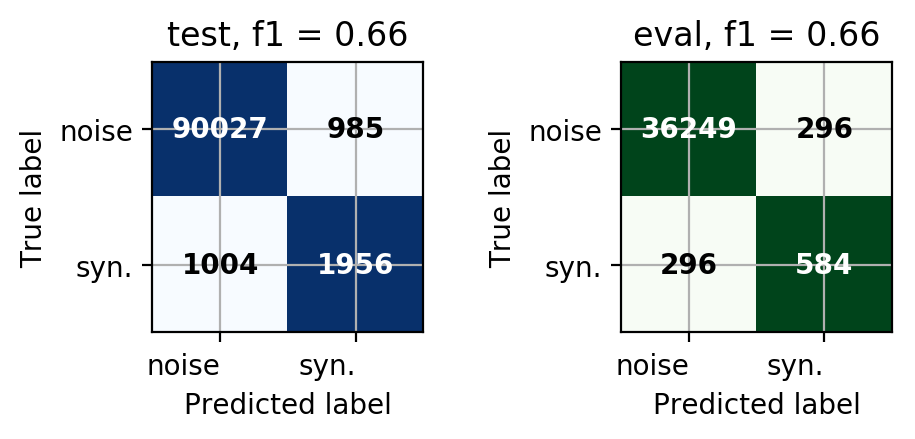

In [42]:
model65.load_weights(save_model_as) # img65_acc_weighted_30_stratif.hdf5
test_and_eval(model65,X_test,y_test,X_eval,y_eval,0.5)

(0.6793393580554691, 0.687603305785124)

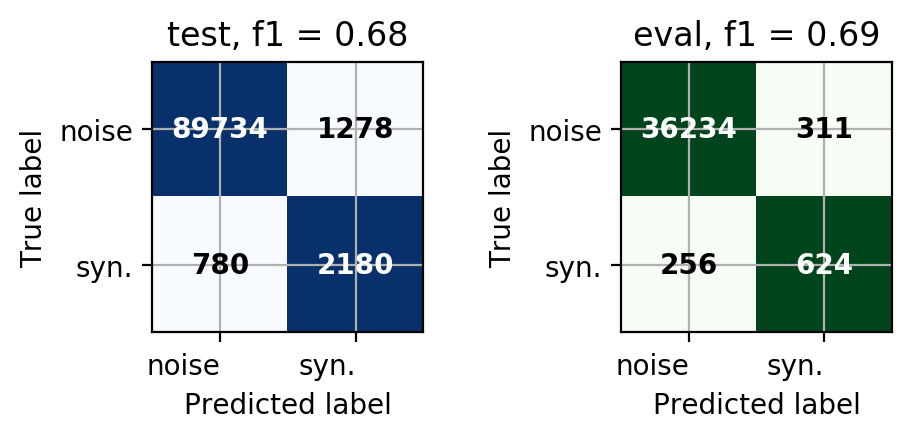

In [40]:
model65.load_weights(save_model_as) # img65_acc_weighted_20_stratif.hdf5
test_and_eval(model65,X_test,y_test,X_eval,y_eval,0.5)

(0.6445532435740513, 0.678963548528766)

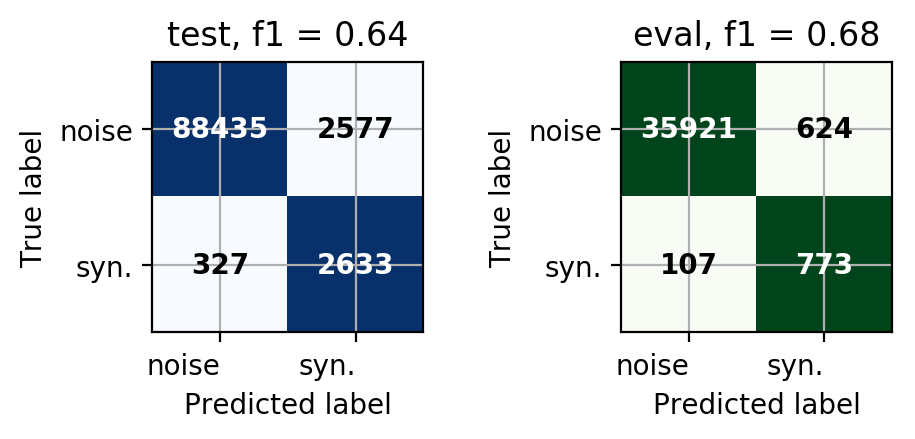

In [38]:
model65.load_weights(save_model_as) # img65_acc_weighted_35_stratif.hdf5
test_and_eval(model65,X_test,y_test,X_eval,y_eval,0.5)

(0.5855894265615007, 0.5842124408875955)

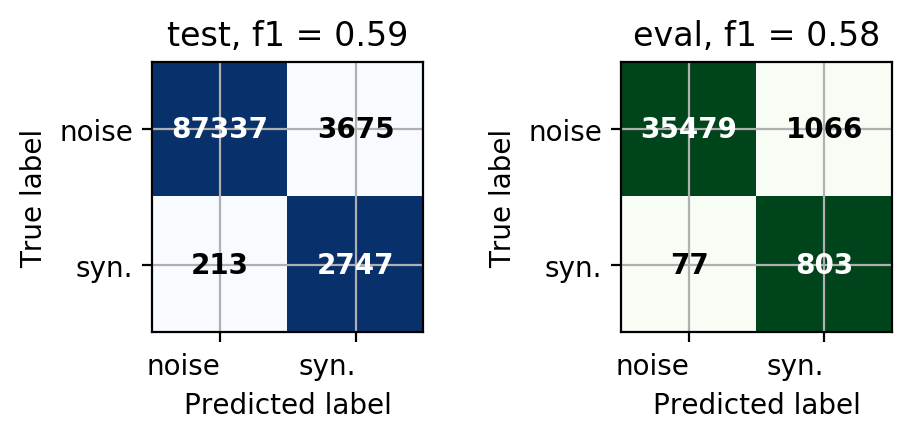

In [36]:
model65.load_weights(save_model_as) # img65_acc_weighted_50_stratif.hdf5
test_and_eval(model65,X_test,y_test,X_eval,y_eval,0.5)

(0.4627929069031032, 0.5045202682997958)

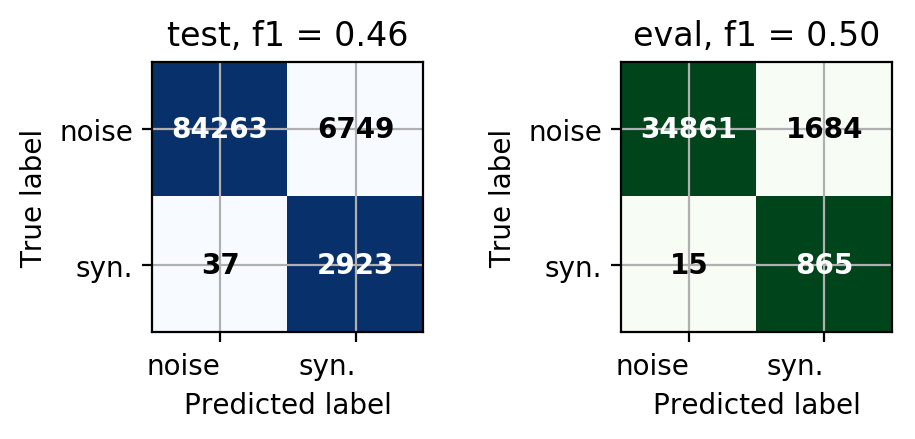

In [34]:
model65.load_weights(save_model_as) # img65_acc_weighted_100_stratif.hdf5
test_and_eval(model65,X_test,y_test,X_eval,y_eval,0.5)

(0.6025885847655421, 0.6372021521906225)

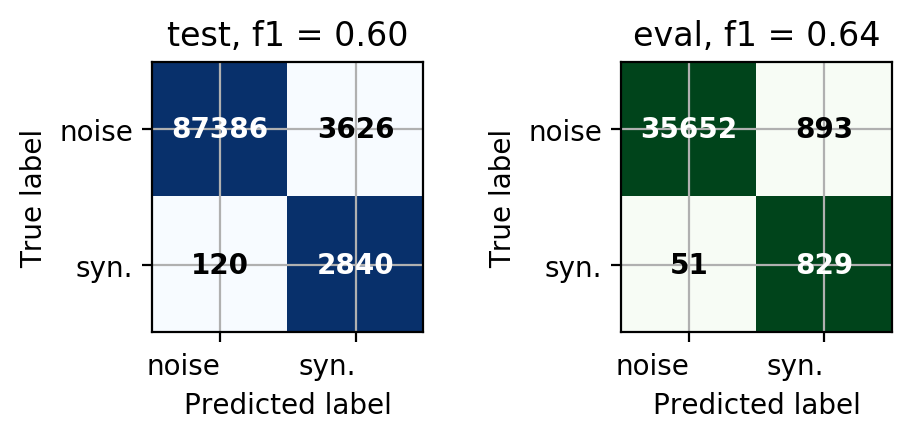

In [31]:
model65.load_weights("best_weights_imgSize65.hdf5")
test_and_eval(model65,X_test,y_test,X_eval,y_eval,0.5)